# Milestone Project 2: SkimLit

The purpose of this project is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll we using) is https://arxiv.org/abs/1710.06071

And reading through the paper we see, that the model architecture that they use to acheive their best results is available here https://arxiv.org/pdf/1612.05251

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
## Get the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# import os

# directory = 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
# files = os.listdir(directory)
# for file in files:
#     print(file)

In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to visualize!

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) ad returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, "r") as f:
        return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")   # Read the lines with the training file
train_lines[:29]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

## Change the look of data
We will make dictionaries

```python
[{
    'line_number': 0,
    'target': 'BACKGROUND',
    'text': "Emotional eating is associated with overeating and the development of obesity .\n",
    'total_lines': 11,
},
    ...]

In [9]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence
    number the target line is
    """
    input_lines = get_lines(filename)   # get all lines from filename
    abstract_lines = "" # Create an empty abstract
    abstract_samples = [] # Create an empty line of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):  # Check to see if it is the ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line

        elif line.isspace():    # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines()  # split abstract into seperate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t")   # Split target label from text
                line_data["target"] = target_text_split[0]  # Get target label
                line_data["text"] = target_text_split[1].lower()    # get target text and lower it
                line_data["line_number"] = abstract_line_number     # What number line does the line appear in the abstract
                line_data["total_lines"] = len(abstract_line_split) - 1     # How many total lines are there in the target abstract
                abstract_samples.append(line_data)  # add line data to abstract samples list
        else: #if the above conditions aren't fullfilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples


In [10]:
import time

# get data from file and preprocess it
start_time = time.time()

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")   # dev is another name for validation
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")
print(f"Lengths: {len(train_samples)}, {len(val_samples)}, {len(test_samples)}")

Execution time: 1.61 seconds
Lengths: 180040, 30212, 30135


In [11]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, we can turn it into a DataFrame to further visualize it

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

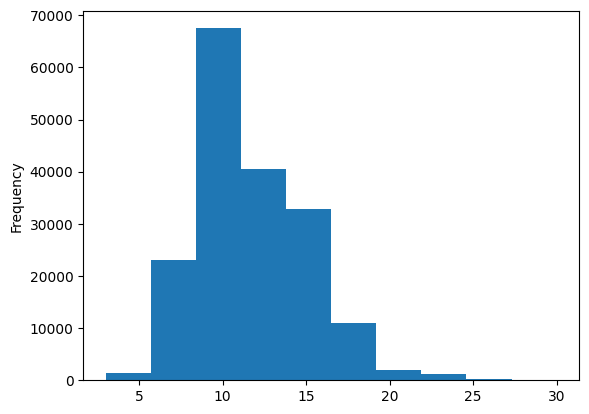

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences


In [15]:
# Convert abstract text lines int lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models requires numberic labels)

In [17]:
# One hot encode
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)    # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Starting a series of modelling experiments

## Model 0:  Getting a baseline

In [20]:
# Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
###

In [25]:
from helper_functions import calculate_results

In [26]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models
Before we start building deeper models, we've got to create vectorization and embeddings layers

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [28]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

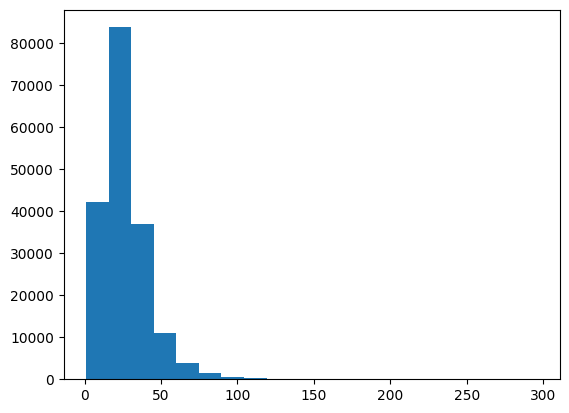

In [30]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [31]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maxmimum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our words to numbers

In [33]:
# How many words we need in our vocab
max_tokens = 68000 #(taken from https://arxiv.org/pdf/1710.06071)

In [34]:
# Create a text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,  # number of words in vocabulary
                                    output_sequence_length=output_seq_len)  # Desired output length of vectorized sequences


In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Text out tex vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the primary aim of the study is to assess the effect of an intensive day-camp intervention on body mass index ( bmi ) in overweight children .

Length of text: 27

Vectorized text: [[    2    56   267     4     2    17    20     6   216     2    70     4
     26   642 31827    38    18   239   385   203   456     5  1065   109
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")


Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of our
                               output_dim=128,
                               mask_zero=True,  # Use marking to handle variable sequence lengths (save space)
                               name="token_embedding")

In [40]:
# Show an exampel embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding): \n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 the primary aim of the study is to assess the effect of an intensive day-camp intervention on body mass index ( bmi ) in overweight children .

Sentence after vectorization (before embedding): 
 [[    2    56   267     4     2    17    20     6   216     2    70     4
     26   642 31827    38    18   239   385   203   456     5  1065   109
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.04231728 -0.01398689 -0.01378367 ... -0.00850945 -0.02260943
    0.00785578]
  [-0.04005277  0.00425445 -0.00092413 ... -0.00172709  0.01175039
    0.02448164]
  [-0.01070319 -0.02458602 -0.03987549 ...  0.02069788 -0.00411471
    0.03500701]
  ...
  [ 0.01051144 -0.00354819  0.02617127 ... -0.03930207  0.00367095
   -0.02117713]
  [ 0.01051144 -0.00354819  0.02617127 ... -0.03930207  0.0036709

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API

In [41]:
# Turn our data into TensoFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the TensorsliceDataset's and turn them into prefechted datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [43]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)  # vectorize text inputs
token_embeddings = token_embed(text_vectors)    # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)  # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [44]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on the 10% of batches to save time


Epoch 1/3
562/562 [==============================] - 80s 140ms/step - loss: 0.9155 - accuracy: 0.6414 - val_loss: 0.6877 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 81s 144ms/step - loss: 0.6638 - accuracy: 0.7531 - val_loss: 0.6383 - val_accuracy: 0.7630
Epoch 3/3
562/562 [==============================] - 76s 135ms/step - loss: 0.6218 - accuracy: 0.7717 - val_loss: 0.6007 - val_accuracy: 0.7859


In [45]:
# Evaluate on while validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 0.6044 - accuracy: 0.7848


[0.6043851375579834, 0.7847874760627747]

In [46]:
# Make predictions (our model predicts prediction probability for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 6s 6ms/step


(array([[4.4046438e-01, 1.4648911e-01, 7.5910918e-02, 3.1300199e-01,
         2.4133585e-02],
        [4.2243785e-01, 2.9876092e-01, 1.2637483e-02, 2.5824139e-01,
         7.9222964e-03],
        [1.6813469e-01, 1.1576579e-02, 2.7308988e-03, 8.1753510e-01,
         2.2732806e-05],
        ...,
        [7.4155478e-06, 6.9162319e-04, 9.0120191e-04, 3.4730494e-06,
         9.9839622e-01],
        [5.3823777e-02, 4.8644981e-01, 8.1795752e-02, 6.5488130e-02,
         3.1244254e-01],
        [1.5392756e-01, 6.4928585e-01, 4.7489032e-02, 6.3982770e-02,
         8.5314773e-02]], dtype=float32),
 (30212, 5))

In [47]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [49]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.47875016549716,
 'precision': 0.7815520423555494,
 'recall': 0.7847875016549716,
 'f1': 0.7821013259542378}

In [50]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretraine work embeddings: https://tfhub.dev/google/universal-sentence-encoder/4

The paper used GlooVe embeddings. But we will stick with the later created USE pretrained embeddings

In [51]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encorder")

In [52]:
# Test our the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 mean c ( max ) and auc ( ) for abiraterone increased dose-dependently in japanese healthy men ; however , @ % confidential interval ( ci ) was outside the predefined dose-proportionality criteria .
Sentence after embedding:
 [-0.03381517 -0.00845834 -0.03700918 -0.0459078  -0.0310081   0.01216105
 -0.02557504  0.01553173 -0.00730996  0.04853956  0.05875929  0.00664273
 -0.03655894 -0.01474236  0.00891514 -0.01175822 -0.01529454  0.06182316
 -0.01467936  0.06419823  0.00583169 -0.00145157 -0.04132342  0.05913277
  0.03046118  0.06143621 -0.03533015 -0.0645499   0.03741466 -0.06027315]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [53]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: We can add more layers here
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                                              outputs=outputs,
                                              name="model_2_USE_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encorde  (None, 512)               256797824 
 r (KerasLayer)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [54]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 14s 19ms/step - loss: 0.9145 - accuracy: 0.6517 - val_loss: 0.7969 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7687 - accuracy: 0.7028 - val_loss: 0.7540 - val_accuracy: 0.7084
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7526 - accuracy: 0.7124 - val_loss: 0.7391 - val_accuracy: 0.7181


In [55]:
#Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7419 - accuracy: 0.7134


[0.7419130802154541, 0.7133920192718506]

In [56]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 13s 13ms/step


array([[4.2051890e-01, 3.7519976e-01, 2.6519380e-03, 1.9168223e-01,
        9.9471482e-03],
       [3.2496864e-01, 5.1489025e-01, 4.0942384e-03, 1.5288007e-01,
        3.1668784e-03],
       [2.2722282e-01, 1.5288591e-01, 1.6766034e-02, 5.6645948e-01,
        3.6665790e-02],
       ...,
       [1.5414750e-03, 6.3246833e-03, 6.2892400e-02, 8.9501677e-04,
        9.2834646e-01],
       [3.3787747e-03, 4.7781713e-02, 1.9896658e-01, 1.2866345e-03,
        7.4858630e-01],
       [1.6311249e-01, 2.8162566e-01, 5.0247437e-01, 6.4066332e-03,
        4.6380840e-02]], dtype=float32)

In [57]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [58]:
# Calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.33920296570899,
 'precision': 0.7140454609012314,
 'recall': 0.7133920296570899,
 'f1': 0.7103078725201705}

## Model 3: Conv1D with character embeddings

The paper uses a combination of token and character level embeddings

### Creating a character level tokanizer

In [59]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [60]:
# Make a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

  # Text splitting non character level sequence int characters
  split_chars(random_train_sentence)

In [61]:
# Split sequence-level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
# What the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

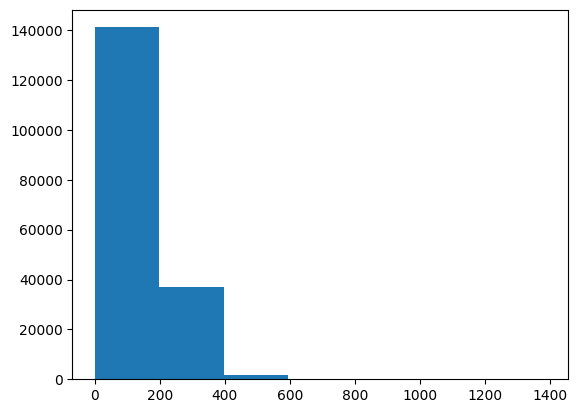

In [63]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [64]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard chracters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2   # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    #standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [67]:
# Adapt character vectorizer to training chracter
char_vectorizer.adapt(train_chars)

In [68]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [69]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars: \n {vectorized_chars}")
print(f"\n Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text: 
 e x p e r i m e n t a l   g r o u p s   w e r e   c u r e d   b y   e i t h e r   c o n v e n t i o n a l   ,   p u l s e - d e l a y   ,   o r   r a m p e d   c u r i n g   m o d e s   o f   l e d   .

Length of random_train_chars: 85

Vectorized chars: 
 [[ 2 24 14  2  8  4 15  2  6  3  5 12 18  8  7 16 14  9 20  2  8  2 11 16
   8  2 10 22 19  2  4  3 13  2  8 11  7  6 21  2  6  3  4  7  6  5 12 14
  16 12  9  2 10  2 12  5 19  7  8  8  5 15 14  2 10 11 16  8  4  6 18 15
   7 10  2  9  7 17 12  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [70]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")


In [71]:
# Test our chracter embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 e x p e r i m e n t a l   g r o u p s   w e r e   c u r e d   b y   e i t h e r   c o n v e n t i o n a l   ,   p u l s e - d e l a y   ,   o r   r a m p e d   c u r i n g   m o d e s   o f   l e d   .

Embedded chars (after vectorization and embedding):
 [[[ 0.01974263  0.00429583  0.03054391 ...  0.0205923  -0.04533751
   -0.03937434]
  [ 0.00203095  0.00538332  0.00554993 ... -0.01569504  0.01824537
   -0.00262715]
  [ 0.02207741 -0.04822587  0.00122324 ...  0.02111607 -0.04945815
   -0.02784886]
  ...
  [-0.03380156 -0.02226995 -0.01784128 ...  0.02284149 -0.03521944
    0.00655621]
  [-0.03380156 -0.02226995 -0.01784128 ...  0.02284149 -0.03521944
    0.00655621]
  [-0.03380156 -0.02226995 -0.01784128 ...  0.02284149 -0.03521944
    0.00655621]]]
Character embedding shape: (1, 290, 25)


### Building a Conv1D

In [72]:

# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [73]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [74]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 14s 23ms/step - loss: 1.2660 - accuracy: 0.4868 - val_loss: 1.0344 - val_accuracy: 0.5898
Epoch 2/3
562/562 [==============================] - 12s 22ms/step - loss: 1.0072 - accuracy: 0.5951 - val_loss: 0.9337 - val_accuracy: 0.6376
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.9261 - accuracy: 0.6345 - val_loss: 0.8653 - val_accuracy: 0.6709


In [75]:
#  Make predictions with character model only
model_3_preds_probs = model_3.predict(val_char_dataset)
model_3_preds_probs

945/945 [==============================] - 7s 7ms/step


array([[0.2091188 , 0.20231159, 0.11537009, 0.3468746 , 0.12632485],
       [0.17986463, 0.6908868 , 0.00550153, 0.09269042, 0.03105657],
       [0.12056852, 0.29025084, 0.19884512, 0.3187507 , 0.0715848 ],
       ...,
       [0.05633586, 0.07532995, 0.2932939 , 0.05266067, 0.5223796 ],
       [0.03560711, 0.22466458, 0.28572476, 0.06326622, 0.3907373 ],
       [0.43636402, 0.39326268, 0.08403099, 0.08028659, 0.0060557 ]],
      dtype=float32)

In [78]:
# Covert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 0])>

In [79]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.06977359989408,
 'precision': 0.6566666824732109,
 'recall': 0.6606977359989408,
 'f1': 0.651203603701925}

In [80]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embedding+ chracters embeddings (hybrid embedding layer)

1. Create a token level embedding (similar to model 1)
2. Create a character embedding (similar to model 3)
3. Combine 1 and 2 with a concatenate
4. Build a series a output layers on top of 3 similar to Figure 1 and section 4.2 of paper https://arxiv.org/pdf/1612.05251
5. Construct a model which takes token and character level sequences as input and produces sequence label probabilities as output.


In [84]:
#1. Setup tokten inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu") (token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Droupout, discused in section 4.2 in paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embedding")



In [85]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encorde  (None, 512)                  2567978  

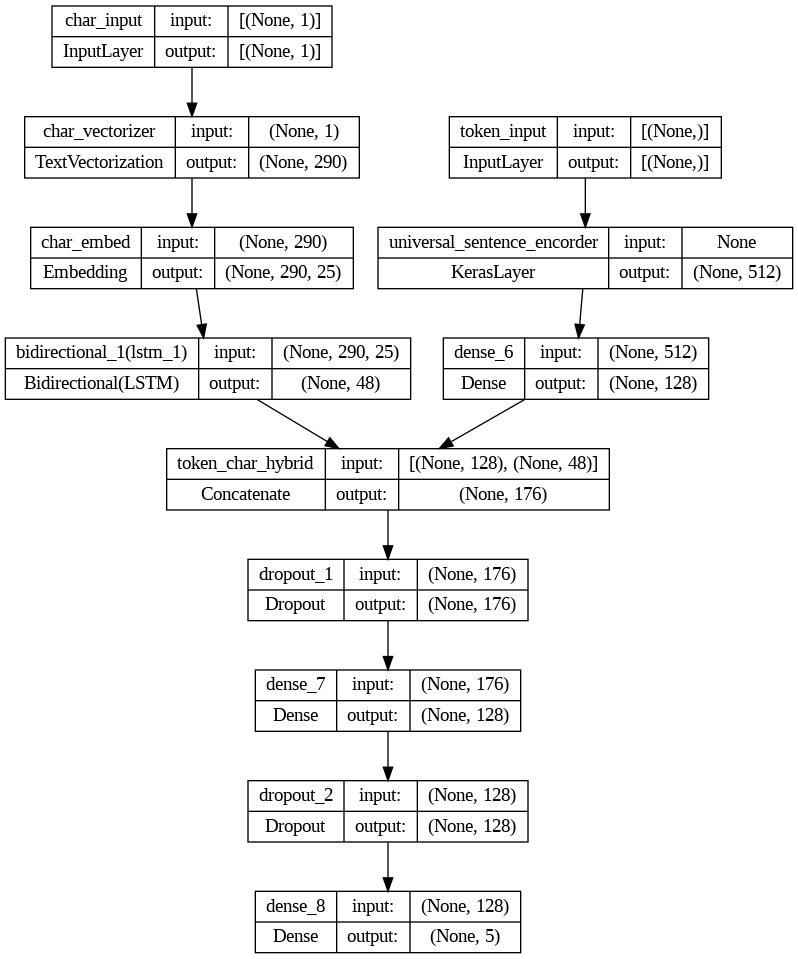

In [88]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [103]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

### Combining token and character data into a tf.Data.Dataset

In [104]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [105]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [106]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 183s 304ms/step - loss: 0.9800 - accuracy: 0.6106 - val_loss: 0.7753 - val_accuracy: 0.6978
Epoch 2/3
562/562 [==============================] - 161s 286ms/step - loss: 0.8050 - accuracy: 0.6902 - val_loss: 0.7116 - val_accuracy: 0.7324
Epoch 3/3
562/562 [==============================] - 168s 299ms/step - loss: 0.7703 - accuracy: 0.7072 - val_loss: 0.6852 - val_accuracy: 0.7374


In [108]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 82s 87ms/step - loss: 0.6909 - accuracy: 0.7357


[0.6909196972846985, 0.7357341647148132]

In [109]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)

945/945 [==============================] - 73s 73ms/step


In [110]:
model_4_pred_probs

array([[3.7579125e-01, 4.4341815e-01, 6.1218492e-03, 1.6273996e-01,
        1.1928793e-02],
       [3.0546644e-01, 5.5057991e-01, 4.5104981e-03, 1.3644736e-01,
        2.9958212e-03],
       [3.3346280e-01, 1.4306372e-01, 6.2876046e-02, 4.1557431e-01,
        4.5023207e-02],
       ...,
       [8.7613653e-04, 1.2426521e-02, 7.1785972e-02, 3.4222633e-04,
        9.1456920e-01],
       [6.2954952e-03, 6.1894175e-02, 2.2412616e-01, 3.0187671e-03,
        7.0466542e-01],
       [2.9956678e-01, 3.9397770e-01, 2.2475910e-01, 2.4840444e-02,
        5.6856059e-02]], dtype=float32)

In [111]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [113]:
# Get results of token-char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.57341453726995,
 'precision': 0.7357045867131413,
 'recall': 0.7357341453726995,
 'f1': 0.7314985215924162}

In [114]:
model_1_results

{'accuracy': 78.47875016549716,
 'precision': 0.7815520423555494,
 'recall': 0.7847875016549716,
 'f1': 0.7821013259542378}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [115]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [116]:
# lines numbers
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

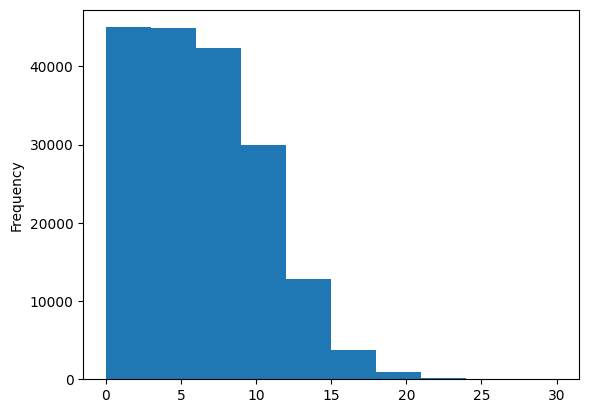

In [119]:
# Check the distrubution of "line_number" column
train_df.line_number.plot.hist()

In [123]:
# Use TensorFloow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape


(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [124]:
# Different nummber of lines are there
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

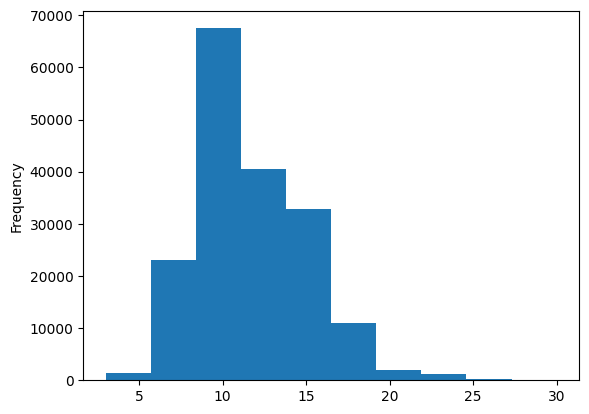

In [125]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [127]:
# Check the coverage of "total_lines" value of 20
np.percentile(train_df.total_lines, 98)


20.0

In [131]:
# Use TensorFlow too create one-hot encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]


(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token level model
2. Create a character level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3 ,4 and the outputs of 7 into tf.keras.Model

In [137]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [139]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encorde  (None, 512)                  2567978   

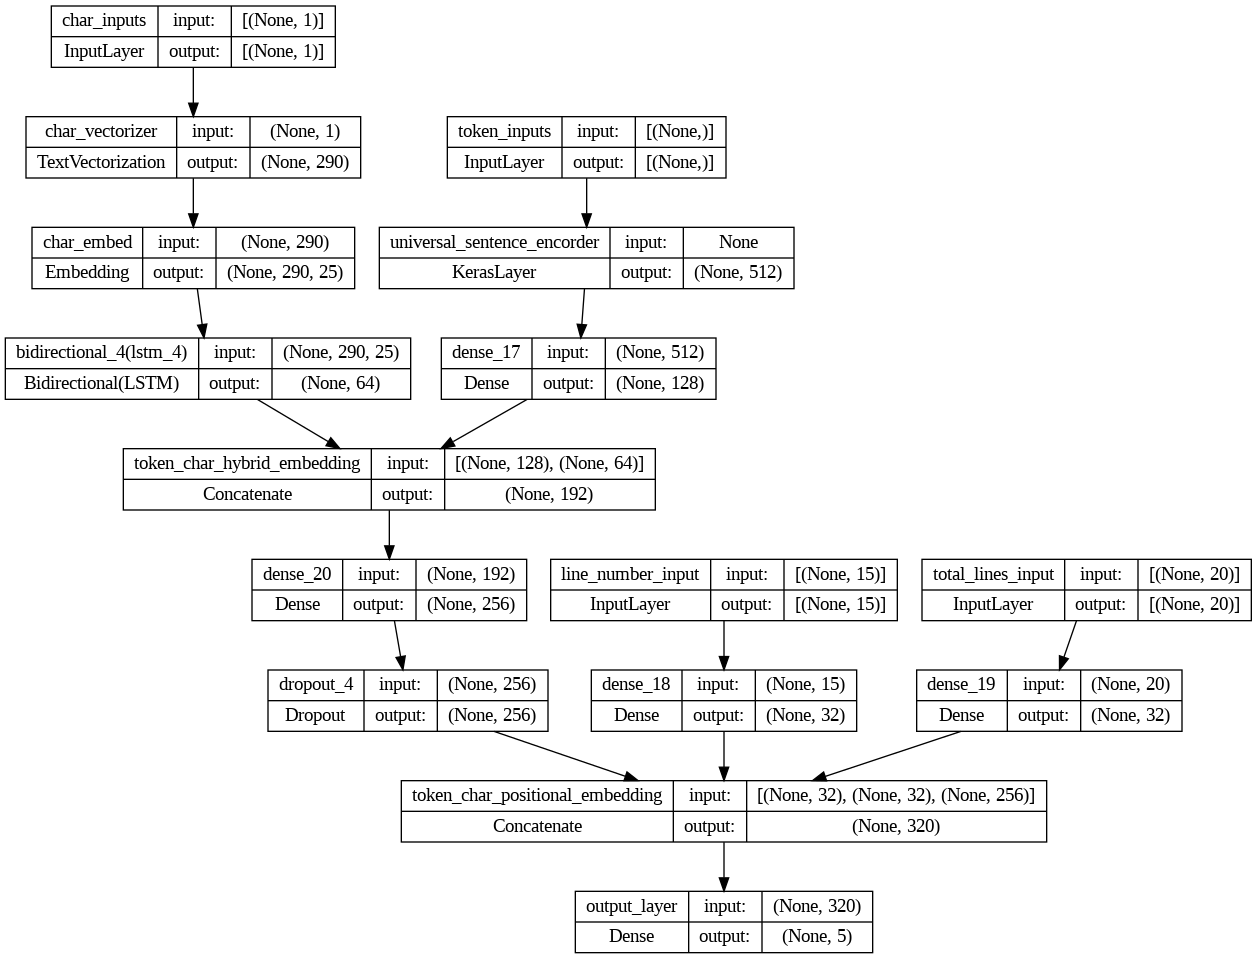

In [141]:
# Plot the model
plot_model(model_5, show_shapes=True)

In [142]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),    # Helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Create tribrid embedding datasets using tf.data

In [146]:
# Create training and validation datasets (for all 4 kinds of inputs)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                               train_total_lines_one_hot,
                                                               train_sentences,
                                                               train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                               val_total_lines_one_hot,
                                                               val_sentences,
                                                               val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [148]:
# Chek input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [149]:
# Fit the model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))


Epoch 1/3
562/562 [==============================] - 243s 404ms/step - loss: 1.1011 - accuracy: 0.7226 - val_loss: 0.9847 - val_accuracy: 0.8049
Epoch 2/3
562/562 [==============================] - 183s 326ms/step - loss: 0.9681 - accuracy: 0.8143 - val_loss: 0.9513 - val_accuracy: 0.8311
Epoch 3/3
562/562 [==============================] - 180s 320ms/step - loss: 0.9499 - accuracy: 0.8243 - val_loss: 0.9392 - val_accuracy: 0.8334


In [150]:
# Make predictions with char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 73s 73ms/step


array([[0.4962369 , 0.10329598, 0.00959579, 0.37377116, 0.0171003 ],
       [0.55485535, 0.08057692, 0.04808019, 0.30818492, 0.0083026 ],
       [0.31389874, 0.10198759, 0.13530011, 0.37653625, 0.07227723],
       ...,
       [0.03278422, 0.08303905, 0.03766097, 0.03062208, 0.8158937 ],
       [0.02941567, 0.27705333, 0.08475364, 0.02802326, 0.5807541 ],
       [0.17349863, 0.5871349 , 0.12023655, 0.03263813, 0.08649172]],
      dtype=float32)

In [151]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [152]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.33112670462069,
 'precision': 0.8322487435852832,
 'recall': 0.8333112670462068,
 'f1': 0.83208132842935}

## Compare model results

In [162]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results


,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.478750,0.781552,0.784788,0.782101
pretrained_token_embed,71.339203,0.714045,0.713392,0.710308
custom_char_embed_conv1d,66.069774,0.656667,0.660698,0.651204
hybrid_char_token_embed,73.573415,0.735705,0.735734,0.731499
tribrid_pos_char_token_embed,83.331127,0.832249,0.833311,0.832081


In [163]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


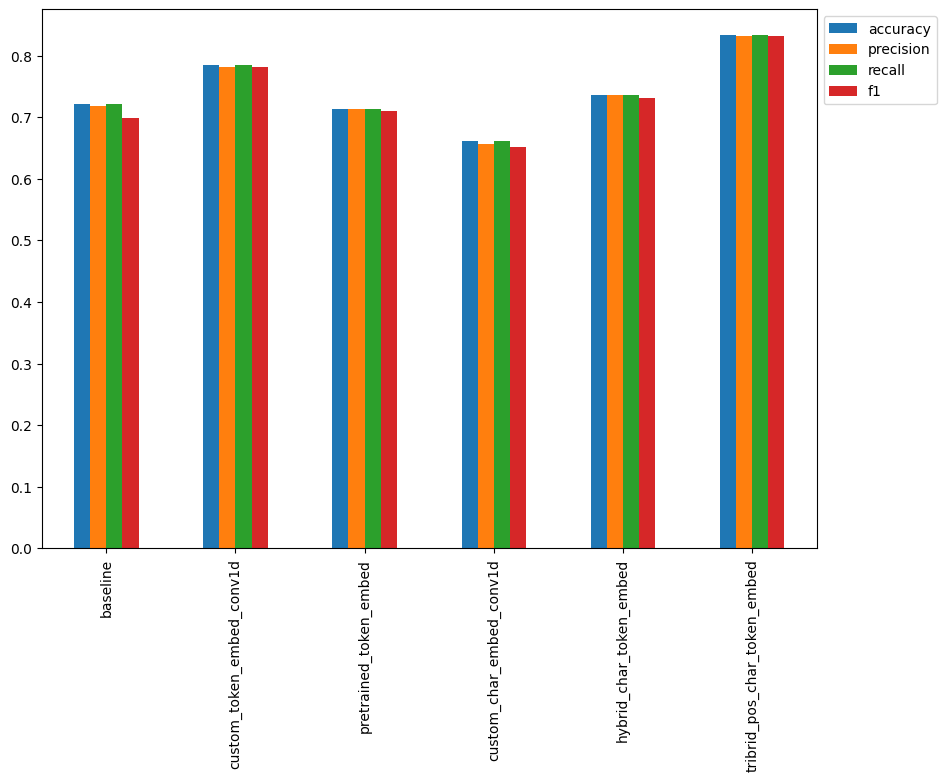

In [164]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


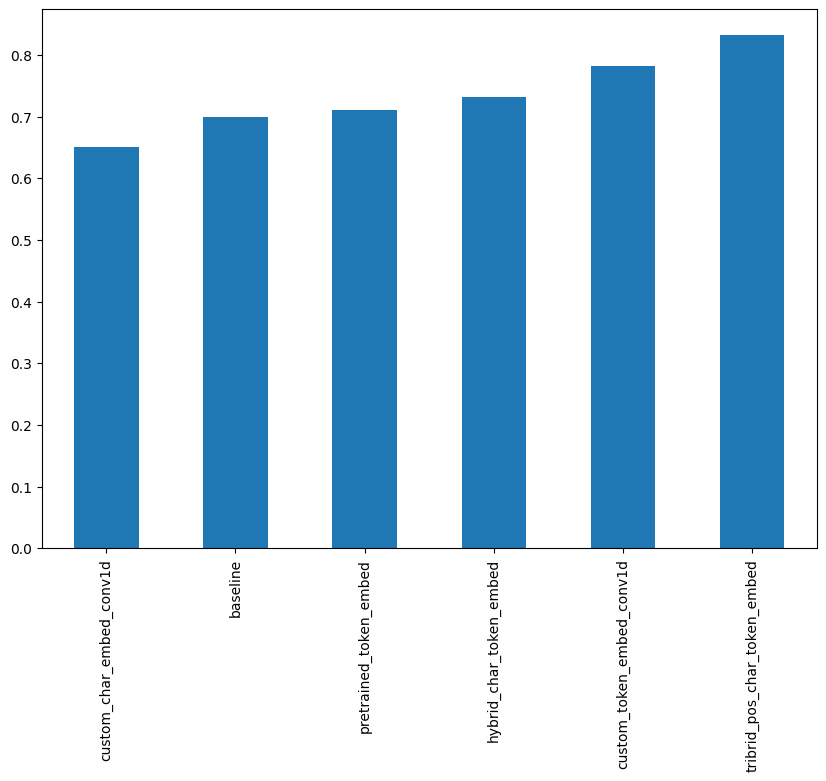

In [167]:
# Sort models by f1 score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load model

In [168]:
model_5.save("skimlit_tribrid_model")

In [169]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [170]:
# Make some predictions with it
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 98s 98ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [171]:
# Calculate the results of the loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.33112670462069,
 'precision': 0.8322487435852832,
 'recall': 0.8333112670462068,
 'f1': 0.83208132842935}

In [172]:
model_5_results

{'accuracy': 83.33112670462069,
 'precision': 0.8322487435852832,
 'recall': 0.8333112670462068,
 'f1': 0.83208132842935}

In [173]:
assert model_5_results == loaded_model_results

In [174]:
# Check loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encorde  (None, 512)                  2567978   